# Análisis de series temporales mediante RNN

**¿Qué es una RNN (Red Neuronal Recurrente)?**

Una RNN es un tipo de red neuronal diseñada específicamente para trabajar con datos secuenciales, como series temporales. La característica principal de una RNN es que tiene "memoria" - puede recordar información de pasos anteriores de la secuencia. Esto la hace ideal para datos donde el contexto temporal es importante.

**Características clave de las RNNs:**

Conexiones recurrentes: A diferencia de las redes neuronales tradicionales, las RNNs tienen conexiones que forman ciclos, permitiendo que la información persista.
Estado oculto: Mantienen un estado interno (hidden state) que funciona como una "memoria" de la secuencia procesada hasta el momento.
Capacidad de procesar secuencias: Pueden manejar entradas de longitud variable y producir salidas correspondientes.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

# Generación datos sintéticos

In [43]:
np.random.seed(42)
time = np.arange(0, 1000)
series = np.sin(0.02 * time) + 2 * np.sin(0.05 * time) + np.random.normal(0, 0.2, size=len(time))

# Visualización datos sintéticos

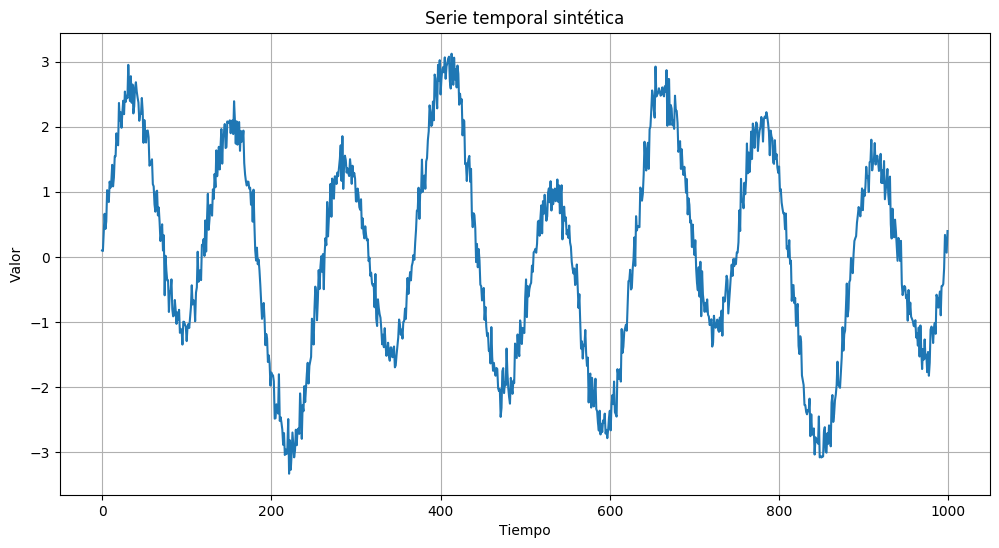

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(time, series)
plt.title('Serie temporal sintética')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Normalización serie temporal

In [45]:
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1)) # el reshape se hace para que el scaler pueda trabajar con la lista de valores

# Creación de dataset

Esta sección:

Define una función create_dataset que transforma la serie temporal en un conjunto de datos supervisado. Para cada punto, toma los look_back valores anteriores como características (X) y el siguiente valor como objetivo (y).
Normaliza los datos con MinMaxScaler para llevarlos al rango [0,1], lo que ayuda a la convergencia del modelo.
Divide los datos en conjuntos de entrenamiento (70%) y prueba (30%).
Configura un look_back de 30, lo que significa que usaremos 30 valores anteriores para predecir el siguiente.
Reorganiza los datos al formato esperado por la RNN: [batch_size, time_steps, features]

In [46]:
def create_dataset(series, look_back=1):
    X, y = [], []
    for i in range(len(series)-look_back):
        X.append(series[i:(i+look_back)])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

# División datos en Train y Test

In [47]:
train_size = int(len(series_scaled) * 0.7)
test_size = len(series_scaled) - train_size
train, test = series_scaled[0:train_size], series_scaled[train_size:len(series_scaled)]

look_back = 30
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

## Reshape

En tu caso, como estás trabajando con una serie temporal unidimensional (una sola variable en cada punto de tiempo, es decir, solo el valor de la serie en ese instante), cada "característica" es 1.

Por lo tanto, la función reshape se usa para cambiar las dimensiones de las variables de entrada (X_train y X_test) y convertirlas a la forma que espera la RNN.

La forma original de X_train antes del reshape es (n_samples, look_back), es decir, un arreglo bidimensional con n_samples muestras y look_back pasos de tiempo (por cada muestra).

El reshape convierte la forma a (n_samples, look_back, 1), lo que es necesario porque las RNN esperan una estructura tridimensional, en la que la tercera dimensión es el número de características de cada paso de tiempo.

En resumen:

- Original: (muestras, look_back) — donde muestras es el número de ejemplos y look_back es el número de pasos de tiempo por ejemplo.
- Después del reshape: (muestras, look_back, 1) — donde el 1 indica que hay una sola característica por paso de tiempo.

In [48]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Creación del modelo

In [49]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(look_back, 1), activation='tanh'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento del modelo

In [50]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 1s 2ms/sample - loss: 0.1397 - val_loss: 0.1273
Epoch 2/50
603/603 [==============================] - 0s 282us/sample - loss: 0.0197 - val_loss: 0.0070
Epoch 3/50
603/603 [==============================] - 0s 283us/sample - loss: 0.0042 - val_loss: 0.0043
Epoch 4/50
603/603 [==============================] - 0s 282us/sample - loss: 0.0026 - val_loss: 0.0031
Epoch 5/50
603/603 [==============================] - 0s 272us/sample - loss: 0.0024 - val_loss: 0.0028
Epoch 6/50
603/603 [==============================] - 0s 272us/sample - loss: 0.0023 - val_loss: 0.0028
Epoch 7/50
603/603 [==============================] - 0s 270us/sample - loss: 0.0022 - val_loss: 0.0024
Epoch 8/50
603/603 [==============================] - 0s 270us/sample - loss: 0.0021 - val_loss: 0.0026
Epoch 9/50
603/603 [==============================] - 0s 272us/sample - loss: 0.0021 - val_loss: 0.0028
Epoch 10/50
603/603 [

## Visualizamos la pérdida durante el entrenamiento

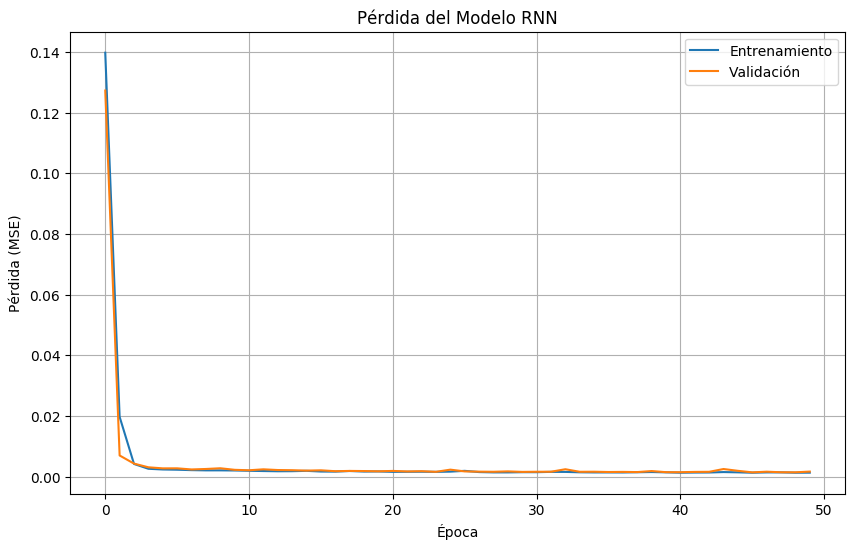

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo RNN')
plt.ylabel('Pérdida (MSE)')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.show()

# Realización de predicciones

In [61]:
X_train.shape

(670, 30, 1)

In [52]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

## Invertimos la normalización de los datos para ver si parecen a los originales

In [53]:
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo de los errores

In [54]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'RMSE Entrenamiento: {train_rmse:.3f}')
print(f'RMSE Prueba: {test_rmse:.3f}')

RMSE Entrenamiento: 0.241
RMSE Prueba: 0.230


# Visualización de resultados

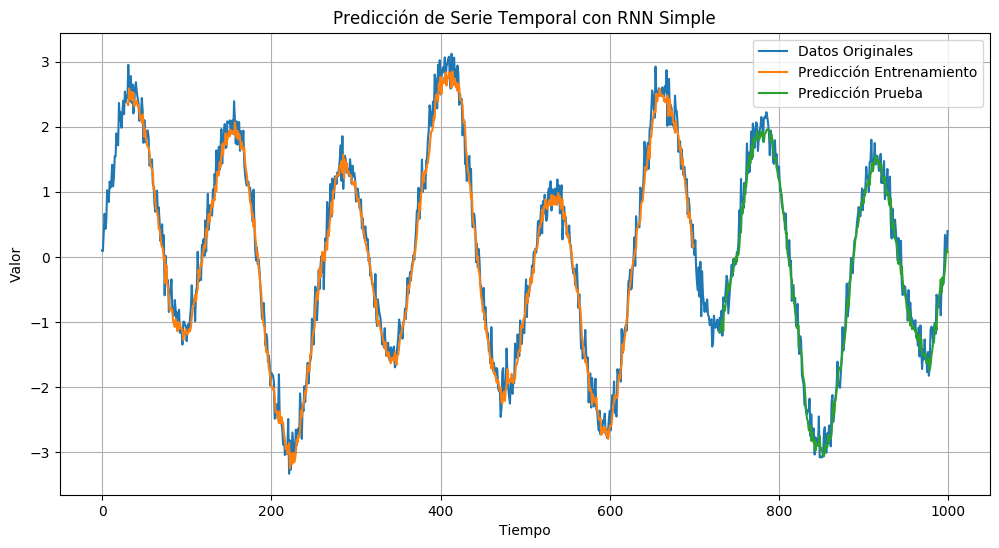

In [60]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
# Ajustar los índices para la visualización
train_plot = np.empty_like(series_scaled)
train_plot[:] = np.nan
train_plot[look_back:train_size] = train_predict

test_plot = np.empty_like(series_scaled)
test_plot[:] = np.nan
test_plot[train_size+look_back:len(series_scaled)] = test_predict

# Convertir de nuevo a la escala original
plt.plot(time, series, label='Datos Originales')
plt.plot(time, train_plot, label='Predicción Entrenamiento')
plt.plot(time, test_plot, label='Predicción Prueba')
plt.title('Predicción de Serie Temporal con RNN Simple')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()